# Case study

We followed the same reasoning and values to model the problem as in the **Stan-case-study** file. But in this case we used another very powerful MCMC sampling software, called Timedeppar. It is a R package specifically designed for Bayesian inference with time-dependent, stochastic parameters.

In [1]:
install.packages('timedeppar')
install.packages('invgamma')
library(timedeppar)
library(invgamma)
seed = 12345

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: mvtnorm



In [2]:
# set colors 
col_red <- '#E21B1B'   #red
col_blue <- '#1769E6'  #blue
col_green <- '#00D10A' #green
col_grey <- '#C8CED0'  #gray

In [3]:
df <- read.csv('data/d18O_record.txt', header = T, sep = ',')
n <- nrow(df)

str(df)

'data.frame':	1429 obs. of  2 variables:
 $ t    : int  1250 1350 1450 1550 1650 1750 1850 1950 2050 2150 ...
 $ y_obs: num  0.5558 0.1829 0.6214 -0.2343 0.0635 ...


In [4]:
# cycles by means of the Bretthorst method
N_cycle <- 29
df_cycle <- read.csv('data/d18O_cycles.txt', header = T, sep = ',')

str(df_cycle)

'data.frame':	29 obs. of  5 variables:
 $ period  : num  4321 5973 6308 4792 5587 ...
 $ A       : num  0.178 0.172 0.151 0.148 0.129 ...
 $ sigma_A : num  0.0086 0.0098 0.0119 0.0077 0.0145 0.007 0.0095 0.0111 0.0074 0.0147 ...
 $ ph      : num  1.97 0.69 3.05 4.77 0.24 1.94 3.56 6.26 3.62 0.13 ...
 $ sigma_ph: num  0.04 0.11 0.12 0.1 0.17 0.1 0.15 0.19 0.18 0.13 ...


In [5]:
# cycles
period <- df_cycle[['period']]

# frequencies
freq <- 1/period

In [6]:
# note: the following vectors are the initialization values (Bretthorst)

# A parameters
param_A <- NULL
for (i in 1:N_cycle) {
    temp <- df_cycle[['A']][i]
    names(temp) <- paste0('A.',i)
    param_A <- append(param_A, temp) 
}

# ph parameters
param_ph <- NULL
for (i in 1:N_cycle) {
    temp <- df_cycle[['ph']][i]
    names(temp) <- paste0('ph.',i)
    param_ph <- append(param_ph, temp) 
}

# t parameters
param_t <- NULL
for (i in 1:n) {
    temp <- df[['t']][i]
    names(temp) <- paste0('t.',i)
    param_t <- append(param_t, temp) 
}

# concatenate named vectors
param <- c(param_A, param_ph)

for (name in names(param)) {
    cat(name, ': ', round(param[name], 4), '\n', sep = '')
}

A.1: 0.1782
A.2: 0.1719
A.3: 0.1509
A.4: 0.1478
A.5: 0.1288
A.6: 0.1251
A.7: 0.1182
A.8: 0.1119
A.9: 0.1117
A.10: 0.1085
A.11: 0.1069
A.12: 0.1033
A.13: 0.0995
A.14: 0.0986
A.15: 0.092
A.16: 0.0887
A.17: 0.0885
A.18: 0.0882
A.19: 0.0868
A.20: 0.0757
A.21: 0.0754
A.22: 0.074
A.23: 0.0739
A.24: 0.0738
A.25: 0.073
A.26: 0.0704
A.27: 0.0637
A.28: 0.06
A.29: 0.058
ph.1: 1.97
ph.2: 0.69
ph.3: 3.05
ph.4: 4.77
ph.5: 0.24
ph.6: 1.94
ph.7: 3.56
ph.8: 6.26
ph.9: 3.62
ph.10: 0.13
ph.11: 0.73
ph.12: 5.51
ph.13: 2.83
ph.14: 4.41
ph.15: 2.62
ph.16: 3.65
ph.17: 5.94
ph.18: 0.95
ph.19: 4.62
ph.20: 1.49
ph.21: 0.45
ph.22: 0.22
ph.23: 0.43
ph.24: 1.37
ph.25: 6.16
ph.26: 5.95
ph.27: 5.42
ph.28: 1.87
ph.29: 4.1


In [7]:
# compute Bretthorst fit
fit_data <- function(param_A, param_ph, param_t, freq, N_cycle, n) {

    A <- unname(param_A)
    ph <- unname(param_ph)
    t <- unname(param_t)

    fit <- rep(0, n) 
    for (i in seq(1, N_cycle)) {
        fit <- fit + A[i]*cos(2*pi*freq[i]*t + ph[i])
    }

    return(fit)
}

In [8]:
# compute Bretthorst fit
fit_bret <- fit_data(param_A, param_ph, param_t, freq, N_cycle, n)

In [9]:
plot_fit <- function(df, fit, start, end, file_name) {

    df <- df[start:end,]
    fit <- fit[start:end]

    # plot
    options(repr.plot.width = 22, repr.plot.height = 8)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    # poetic variables
    sigma_y <- 0.2

    plot(df[['t']], df[['y_obs']], ylim = (max(df[['y_obs']]) + 1*sigma_y)*c(-1,1),
        main = paste0('Real dataset with ', file_name),
        xlab = 't_reg [YBP]', ylab = 'y [‰]',
        type = 'l', lty = 1, lwd = 2, col = col_blue,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 2)

    lines(df[['t']], fit, type = 'l', lty = 1, lwd = 2, col = col_green)

    legend(x = start*100 + 0.71*(end-start)*100, y = 1.55, bty = 'n',
        inset = 0.02,
        legend = c('observed data', file_name),
        lty = rep(1,2),
        col = c(col_blue, col_green),
        lwd = rep(2,2),
        cex = 1.3)

}

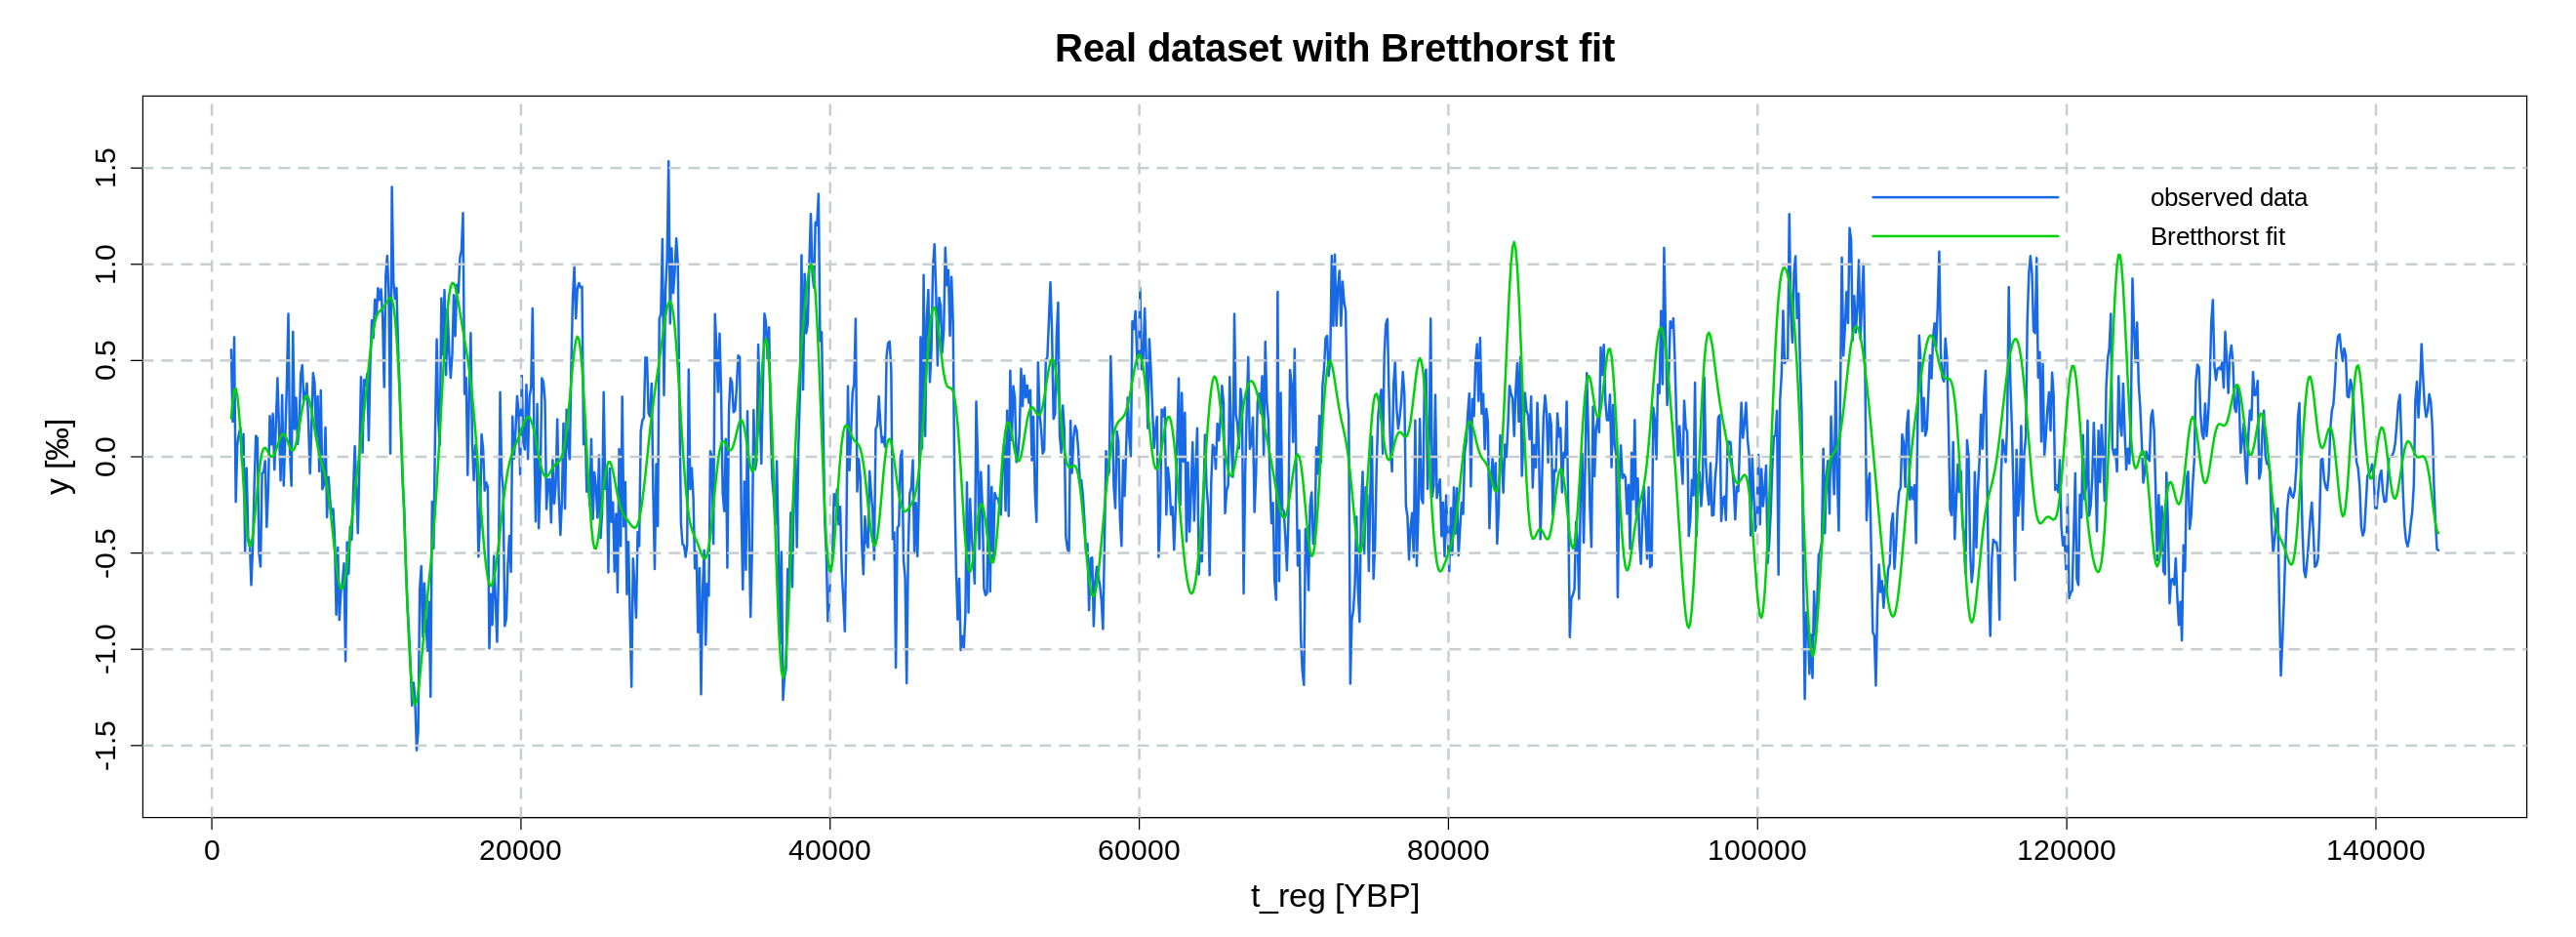

In [10]:
# plot Bretthorst fit
plot_fit(df, fit_bret, 1, n, 'Bretthorst fit')

In [11]:
# number of cycles to be inferred
N_cycle_inf <- 29

In [12]:
# initialization of time-dependant and constant parameters
data <- data.frame('step' = df[['t']], 'init' = rep(100, n), 'y_corr_obs'= df[['y_obs']])
param_init <- list('xi' = data[,c('step','init')], 'sigma_y' = 0.2)
param_init <- c(param_init, param_A[1:N_cycle_inf], param_ph[1:N_cycle_inf])

In [13]:
# ranges of constant parameters
param_range <- list('sigma_y' = c(0,1))

# A parameters range
param_A_range <- NULL
for (i in 1:N_cycle_inf) {
    temp <-  list(c(0,0.5))
    names(temp) <- paste0('A.',i)
    param_A_range <- append(param_A_range, temp) 
}

# ph parameters range
param_ph_range <- NULL
for (i in 1:N_cycle_inf) {
    temp <- list(c(0,2*pi))
    names(temp) <- paste0('ph.',i)
    param_ph_range <- append(param_ph_range, temp) 
}

param_range <- c(param_range, param_A_range, param_ph_range)

In [14]:
# define observational likelihood
loglikeli <- function(param, data) {

    # get parameter xi at time points of observations
    xi <- param$xi

    if ( is.matrix(xi) | is.data.frame(xi) ) {
        xi <- approx(x = xi[,1], y = xi[,2], xout = data[['step']])$y
    }

    # corrupted time
    t_corr <- rep(0, n)
    t_corr[1] <- 1250
    for (i in 2:n) {
            t_corr[i] <- t_corr[i-1] + xi[i]
    }

    # corrupted model
    y_corr <- rep(0, length(t_corr))
    for (i in 1:N_cycle_inf) {
        y_corr <- y_corr + param[[paste0('A.',i)]]*cos(2*pi*freq[i]*t_corr + param[[paste0('ph.',i)]])
    }

    # calculate likelihood
    log_likelihood_y <- sum(dnorm(data[['y_corr_obs']], mean = y_corr, sd = param$sigma_y, log = T))

    # return result
    return(log_likelihood_y)
    
}

In [15]:
# define priors for Orstein-Uhlenbeck parameters
logprior_ou <- function(param_ou) {

    # calculate priors
    log_prior_mean <- dnorm(param_ou[['xi_mean']], mean = 100, sd = 1, log = T)
    log_prior_sd <- dgamma(param_ou[['xi_sd']], shape = 1, rate = 1, log = T)
    log_prior_gamma <- dinvgamma(param_ou[['xi_gamma']], shape = 25, rate = 0.025, log = T)


    # return result
    return(log_prior_mean + log_prior_sd + log_prior_gamma)

}

In [16]:
# define priors for constant parameters
logprior_const <- function(param_const) {

    # calculate priors
    log_prior_sigma_y <- dgamma(param_const[['sigma_y']], shape = 2, rate = 10, log = T)

    # return result
    return(log_prior_sigma_y)

}

In [17]:
# timedeppar settings for MCMC
n_iter <- 200000
n_interval <- 20
n_adapt <- floor(0.2*n_iter)
name = 'run_case'

In [18]:
# bayesian inference
res <- NULL

if (FALSE) {

    res <- infer.timedeppar(loglikeli = loglikeli, 
                        param.ini = param_init,
                        param.range = param_range,
                        param.logprior = logprior_const,
                        param.ou.ini = c(xi_mean = 100, xi_sd = 1, xi_gamma = 1/1000),
                        param.ou.logprior = logprior_ou,
                        n.iter = n_iter,
                        control = list(n.interval = n_interval, n.adapt = n_adapt),
                        file.save = name,
                        data = data)

}

# Results

In [19]:
# import inferred dataframe
load(paste0(name, '.RData'))

In [20]:
# remove burn in and apply thinning
start <- 1 + n_adapt + 1
end <- n_iter + 1
thinning <- 10

In [21]:
df_inf_ou <- as.data.frame(res$sample.param.ou[seq(start, end, thinning),])
df_inf_const <- as.data.frame(res$sample.param.const[seq(start, end, thinning),])
df_inf_timedep <- as.data.frame(res$sample.param.timedep[[1]][seq(start+1, end+1, thinning),])
names(df_inf_timedep) <- paste0(rep('xi.', n), as.character(seq(1, n)))
df_inf <- cbind(df_inf_ou, df_inf_const, df_inf_timedep)

In [22]:
# compute samples of t parameters from xi parameters
df_inf['t.1'] <- rep(1250, nrow(df_inf))

for (i in 2:n) {
	df_inf[paste0('t.',i)] <- df_inf[paste0('t.',(i-1))] + df_inf[paste0('xi.',i)]
}

In [23]:
infer_parameter <- function(names, df) {

    param_inf <- NULL

    for (name in names) {
        temp <- quantile(df[[name]], probs = 0.5)
        names(temp) <- name
        param_inf <- append(param_inf, temp)
    }

    return(param_inf)

}

In [24]:
# Orstein-Uhlenbeck inferred parameters
param_OU_inf = infer_parameter(c('xi_mean', 'xi_sd', 'xi_gamma'), df_inf)

# sigma_y inferred parameter
param_sigma_y_inf = infer_parameter('sigma_y', df_inf)

# A inferred parameters
param_A_inf = infer_parameter(names(param_A)[1:N_cycle_inf], df_inf)

# ph inferred parameters
param_ph_inf = infer_parameter(names(param_ph)[1:N_cycle_inf], df_inf)

# t inferred parameters
param_t_inf = infer_parameter(names(param_t), df_inf)

# concatenate named vectors
param_inf <- c(param_OU_inf, param_sigma_y_inf, param_A_inf, param_ph_inf)

In [25]:
# print inferred parameters
for (name in names(c(param_OU_inf, param_sigma_y_inf))) {

    cat(name, '\n')

    prec <- NULL

    if (is.element(name, c('xi_mean', 'xi_sd'))) {
        prec <- 1
    }
    else if (is.element(name, c('xi_gamma'))) {
        prec <- 4
    }
    else if (is.element(name, c('sigma_y'))) {
        prec <- 3
    }

    cat('inf: ', round(param_inf[name], prec),
        ' +- ', round(sqrt(var(df_inf[name])), prec), '\n', sep = '')
}

xi_mean 
inf: 100 +- 0.9
xi_sd 
inf: 20.3 +- 2.4
xi_gamma 
inf: 0.0011 +- 2e-04
sigma_y 
inf: 0.288 +- 0.006


In [26]:
# print Bretthorst and inferred parameters
for (name in names(c(param_A_inf, param_ph_inf))) {

    cat(name, '\n')
    
    prec <- NULL

    if (is.element(name, paste0(rep('A.', N_cycle_inf), as.character(seq(1, N_cycle_inf))))) {
        prec <- 2
    }
    else if (is.element(name, paste0(rep('ph.', N_cycle_inf), as.character(seq(1, N_cycle_inf))))) {
        prec  <- 1
    }
      
    cat('Bretthorst: ', round(param[name], prec),
        ' inf: ', round(param_inf[name], prec),
        ' +- ', round(sqrt(var(df_inf[name])), prec), '\n', sep = '')
}

A.1 
Bretthorst: 0.18 inf: 0.13 +- 0.02
A.2 
Bretthorst: 0.17 inf: 0.14 +- 0.01
A.3 
Bretthorst: 0.15 inf: 0.2 +- 0.01
A.4 
Bretthorst: 0.15 inf: 0.15 +- 0.01
A.5 
Bretthorst: 0.13 inf: 0.1 +- 0.01
A.6 
Bretthorst: 0.13 inf: 0.12 +- 0.01
A.7 
Bretthorst: 0.12 inf: 0.12 +- 0.02
A.8 
Bretthorst: 0.11 inf: 0.12 +- 0.01
A.9 
Bretthorst: 0.11 inf: 0.13 +- 0.02
A.10 
Bretthorst: 0.11 inf: 0.01 +- 0.02
A.11 
Bretthorst: 0.11 inf: 0.09 +- 0.01
A.12 
Bretthorst: 0.1 inf: 0.16 +- 0.02
A.13 
Bretthorst: 0.1 inf: 0.15 +- 0.02
A.14 
Bretthorst: 0.1 inf: 0.1 +- 0.02
A.15 
Bretthorst: 0.09 inf: 0.04 +- 0.02
A.16 
Bretthorst: 0.09 inf: 0.1 +- 0.02
A.17 
Bretthorst: 0.09 inf: 0.08 +- 0.02
A.18 
Bretthorst: 0.09 inf: 0.05 +- 0.02
A.19 
Bretthorst: 0.09 inf: 0.04 +- 0.02
A.20 
Bretthorst: 0.08 inf: 0.07 +- 0.02
A.21 
Bretthorst: 0.08 inf: 0.08 +- 0.02
A.22 
Bretthorst: 0.07 inf: 0.04 +- 0.02
A.23 
Bretthorst: 0.07 inf: 0.05 +- 0.02
A.24 
Bretthorst: 0.07 inf: 0.02 +- 0.01
A.25 
Bretthorst: 0.07 inf: 0.1 

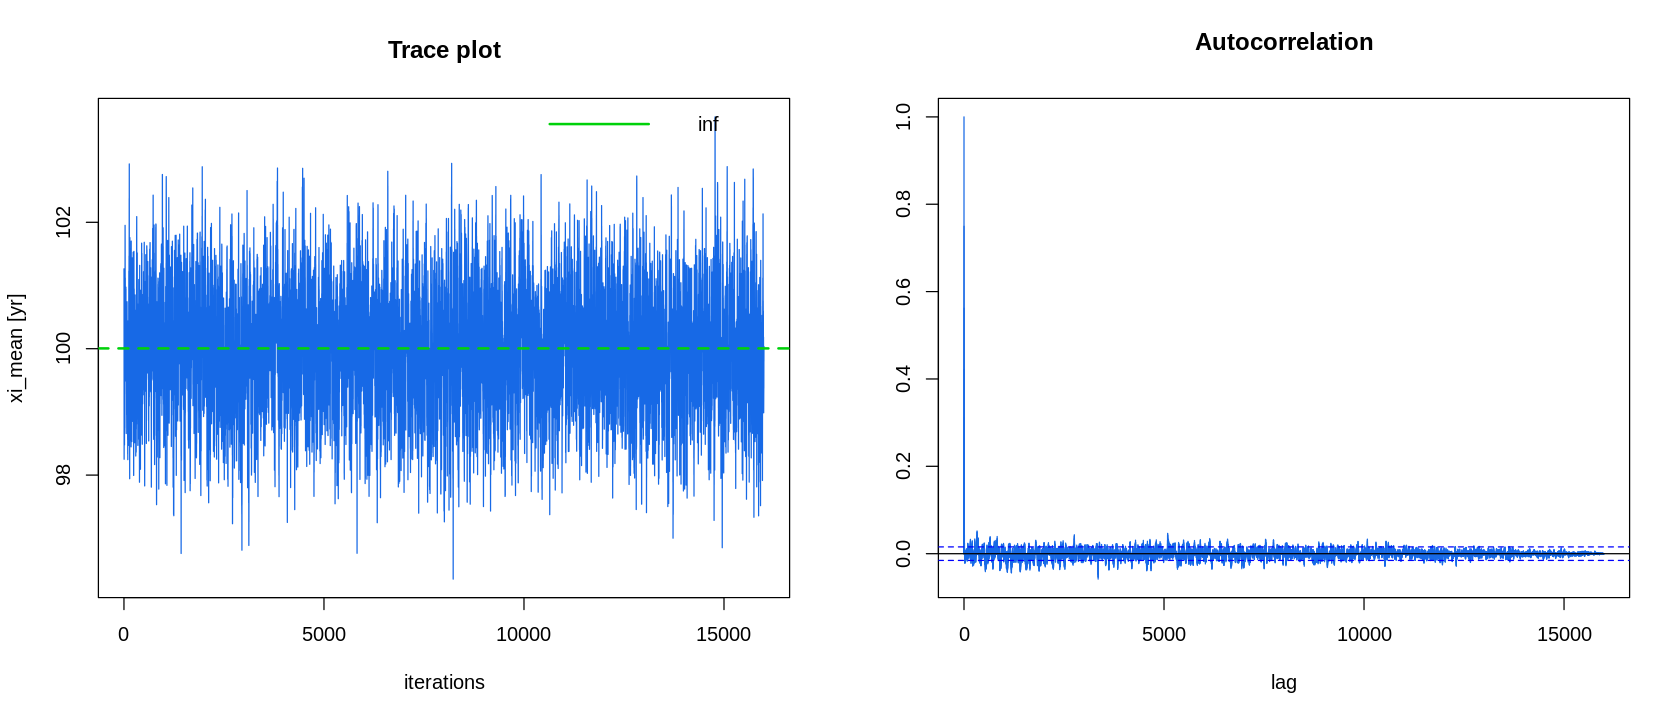

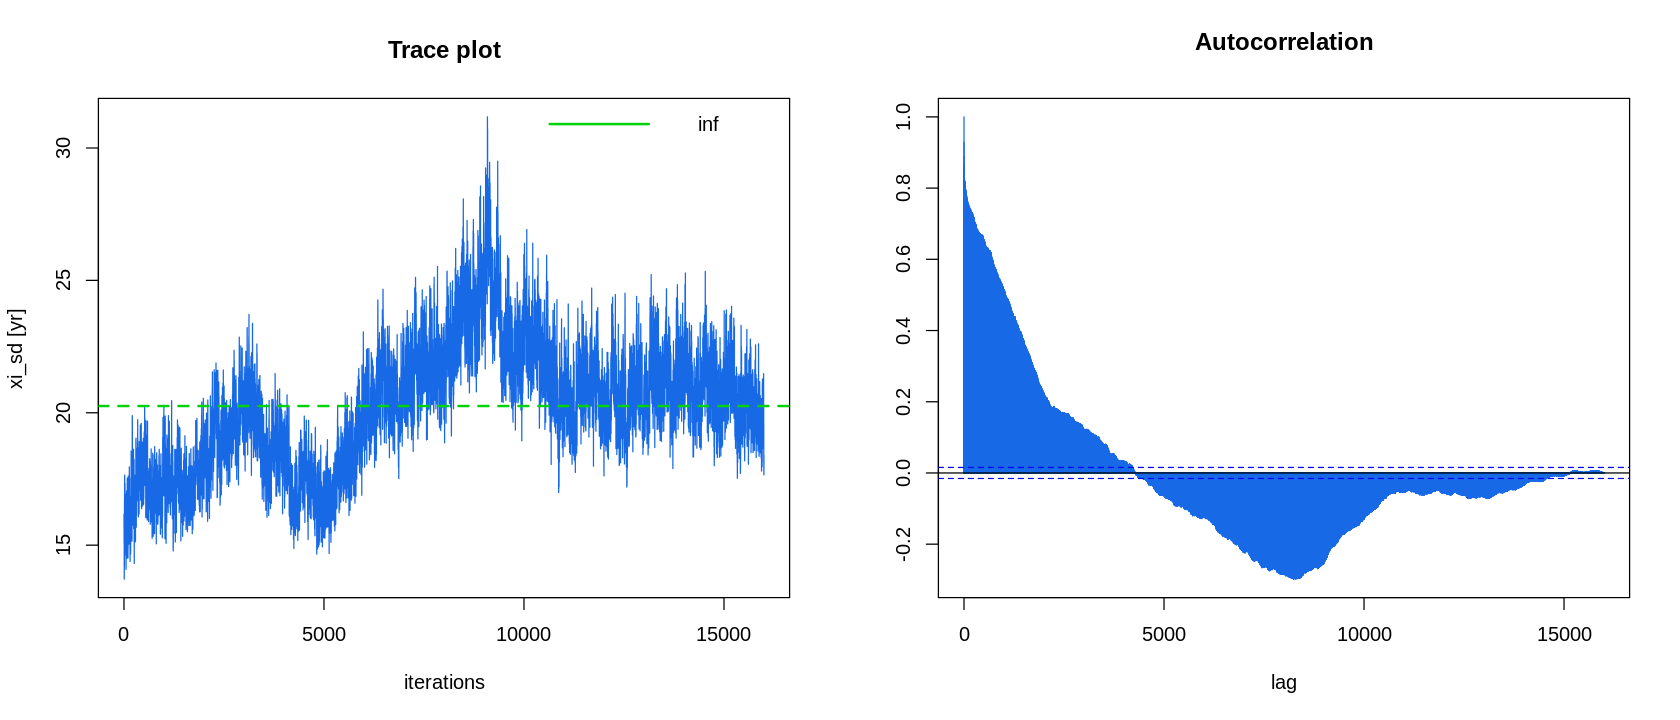

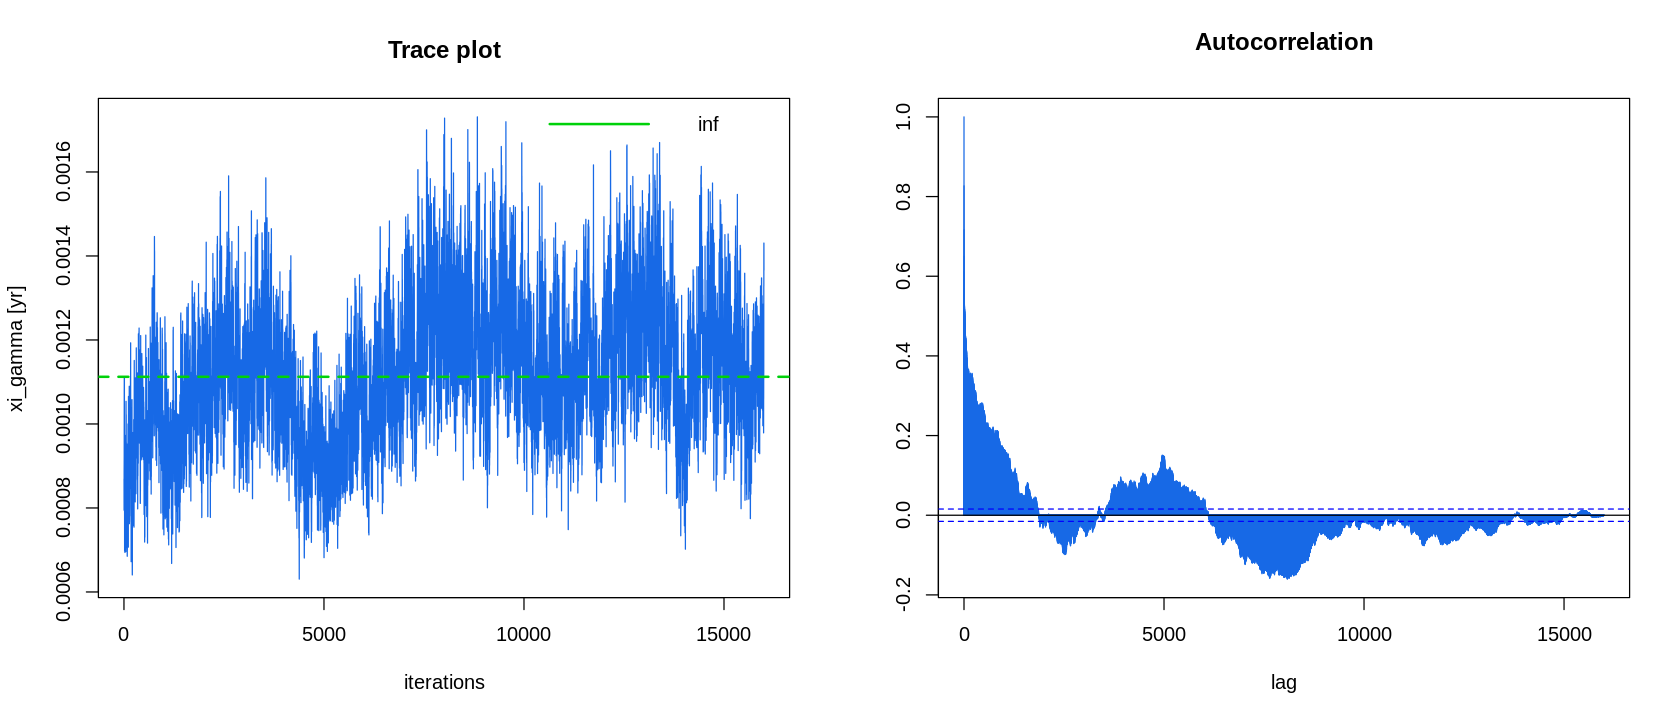

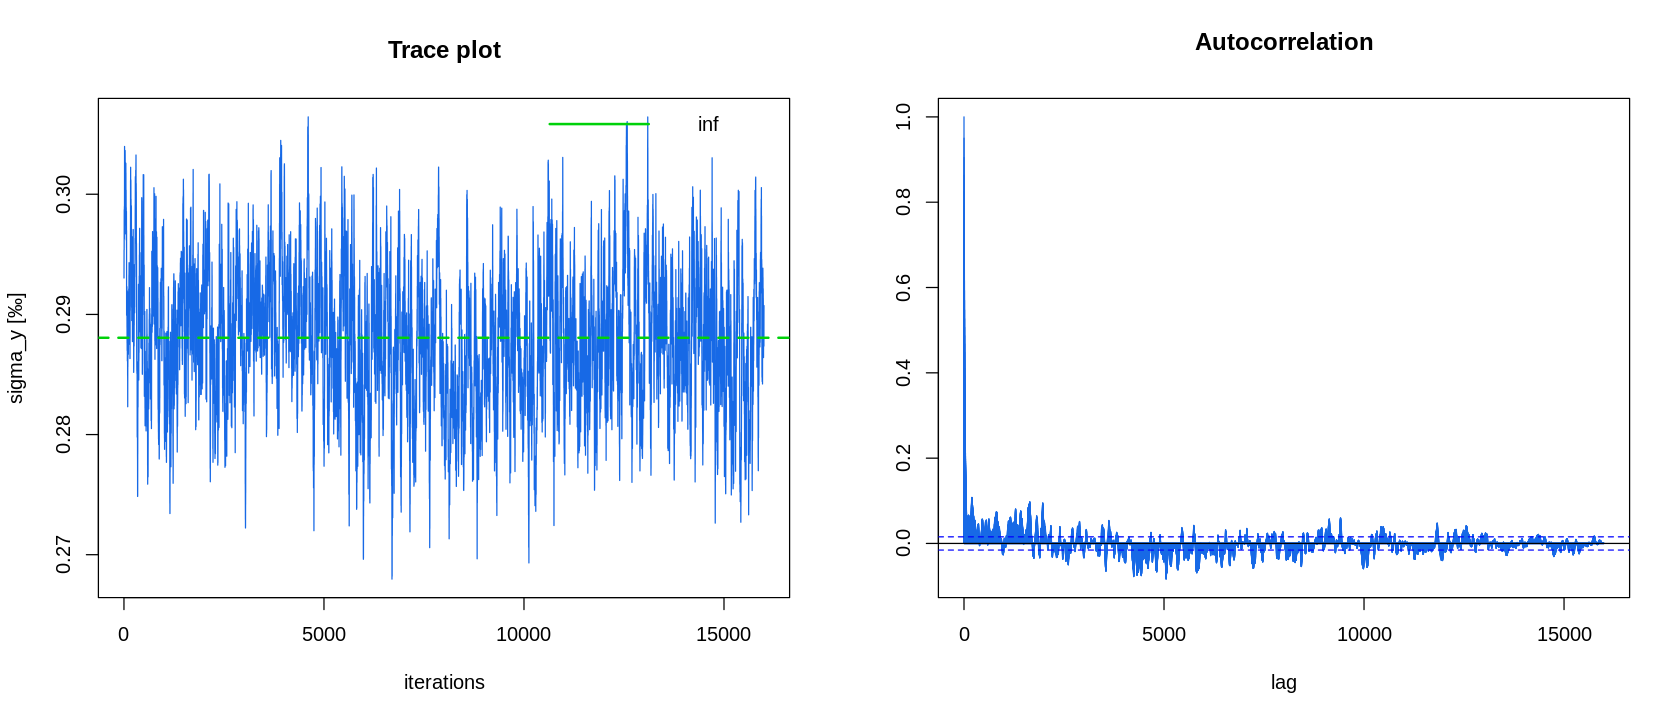

In [27]:
plot_mc_acf <- function(df, key) {

    # plot
    options(repr.plot.width = 14, repr.plot.height = 6)
    par(mfrow = c(1,2))

    if( key == 'sigma_y'){
    # markov chain
    plot(seq(1, nrow(df)), df[[key]],
        main = 'Trace plot',
        xlab = 'iterations', ylab = paste(key, '[‰]'), type = 'l', col = col_blue) }

    else{
    # markov chain
    plot(seq(1, nrow(df)), df[[key]],
        main = 'Trace plot',
        xlab = 'iterations', ylab = paste(key, '[yr]'), type = 'l', col = col_blue)}

    abline(h = median(df[[key]]), col = col_green, lty = 2, lwd = 2)

    legend(x = 'topright', bty = 'n',
    inset = 0.01,
    legend = c('inf'),
    lty = rep(1,1),
    col = c(col_green),
    lwd = rep(2,1))

    # autocorrelation
    acf(df[[key]], lag = length(df[[key]]) - 1,
        main = 'Autocorrelation', xlab = 'lag', ylab = '', col = col_blue)
        
}


for (name in names(c(param_OU_inf, param_sigma_y_inf))) {
    plot_mc_acf(df_inf, name)
}

In [28]:
# plot pairwise scatter plot matrix, histograms and correlation coefficients
scatterplot_matrix <- function(param_inf, n, df) {

    # Orstein-Uhlenbeck and sigma_y
    key <- names(param_inf)[1:4]

    # A
    key <- c(key, paste0(rep('A.', n), as.character(seq(1, n))))

    # ph
    key <- c(key, paste0(rep('ph.', n), as.character(seq(1, n))))

    # plot
    options(repr.plot.width = 16, repr.plot.height = 16)
    par(mar = c(1.5, 2, 1, 1))

    # layout matrix
    n <- 1
    mat <- matrix(0, length(key), length(key))

    # rows
    for (i in 1:length(key)) {

        # columns
        for (j in 1:length(key)) {

            if(j<=i) {
                mat[i,j] <- n
                n <- n + 1
            }
        }
    }

    layout(mat)

    # rows
    for (i in 1:length(key)) {

        # columns
        for (j in 1:length(key)) {

            # histograms
            if (j==i) {
                hist(df[[key[i]]], breaks = 20,
                    main = key[i], col = col_blue)
                box()
                grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 1)
                abline(v = param_inf[[key[i]]], col = col_green, lty = 2, lwd = 2)
            }

            # scatter plots
            else if (j<i) {
                plot(df[[key[j]]], df[[key[i]]], col = col_blue)
                grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 1)
            }
        }
    }
}

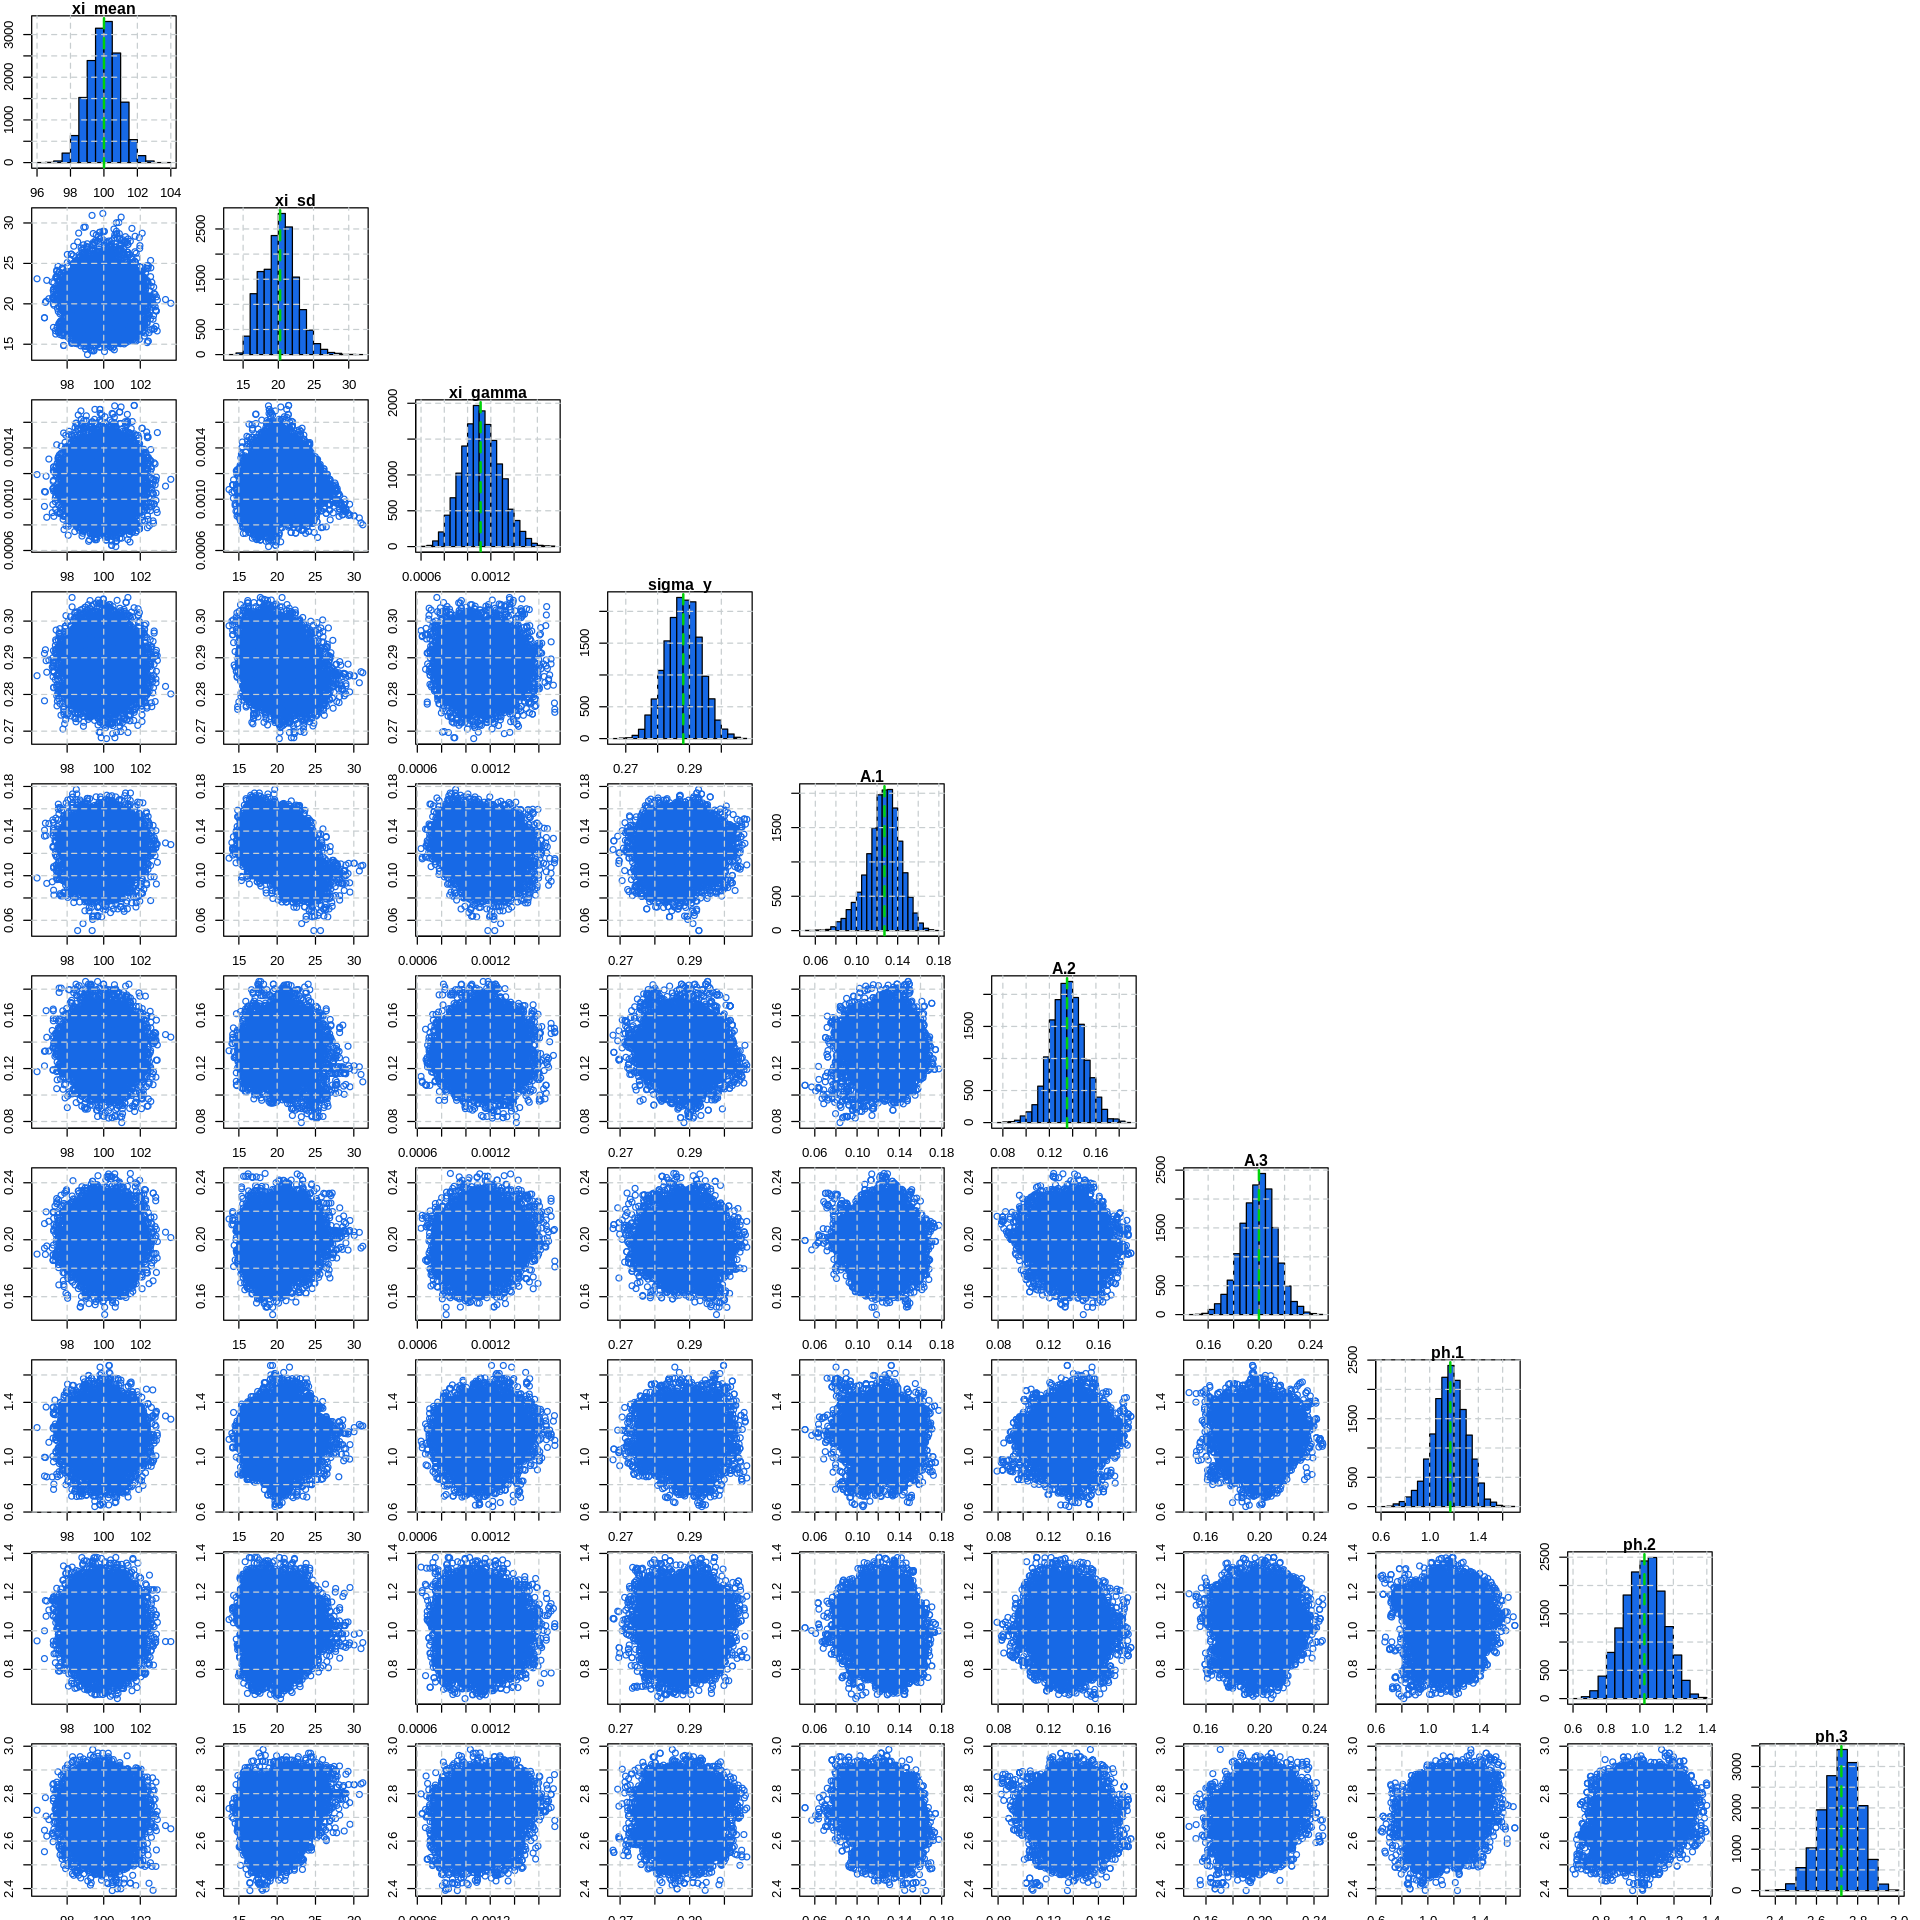

In [29]:
# pairwise scatter plot matrix, histograms (marginals) and correlation coefficients
scatterplot_matrix(param_inf, 3, df_inf)

In [30]:
# plot inferred Orstein-Uhlenbeck model
infer_OU <- function(n, df) {

    names <- paste0(rep('xi.', n), as.character(seq(1, n)))

    # xi inferred parameters and 95% credible interval
    xi_inf <- apply(df[names], 2, quantile, probs = 0.5)
    xi_inf_95CI <- apply(df[names], 2, quantile, probs = c(0.025, 0.975))

    # plot
    options(repr.plot.width = 18, repr.plot.height = 8)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    # poetic variables
    mean <- apply(df['xi_mean'], 2, quantile, probs = 0.5)
    sd <- apply(df['xi_sd'], 2, quantile, probs = 0.5)

    t <- 1250 + seq(0, (n-1)*100, 100)
    plot(t, xi_inf, ylim = mean + 5*c(-sd, sd),
        main = 'Inferred Orstein-Uhlenbeck process',
        xlab = 't_reg [YBP]', ylab = 'xi [yr]',
        type = 'l', lty = 1, lwd = 2, col = col_green,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 2)

    polygon(c(t, rev(t)), 
            c(xi_inf_95CI[1,], rev(xi_inf_95CI[2,])),
            col = col_grey, density = 90, border = FALSE)

    abline(h = 100, col = 'red', lty = 2, lwd = 2)

    lines(t, xi_inf, type = 'l', lty = 1, lwd = 2, col = col_green)

    legend(x = 0.70*n*100, y = mean + 0.93*(5*sd), bty = 'n',
        inset = 0.01,
        legend = c('inference', '95% CI'),
        lty = rep(1,2),
        col = c(col_green, col_grey),
        lwd = rep(2,2),
        cex = 1.3)
}

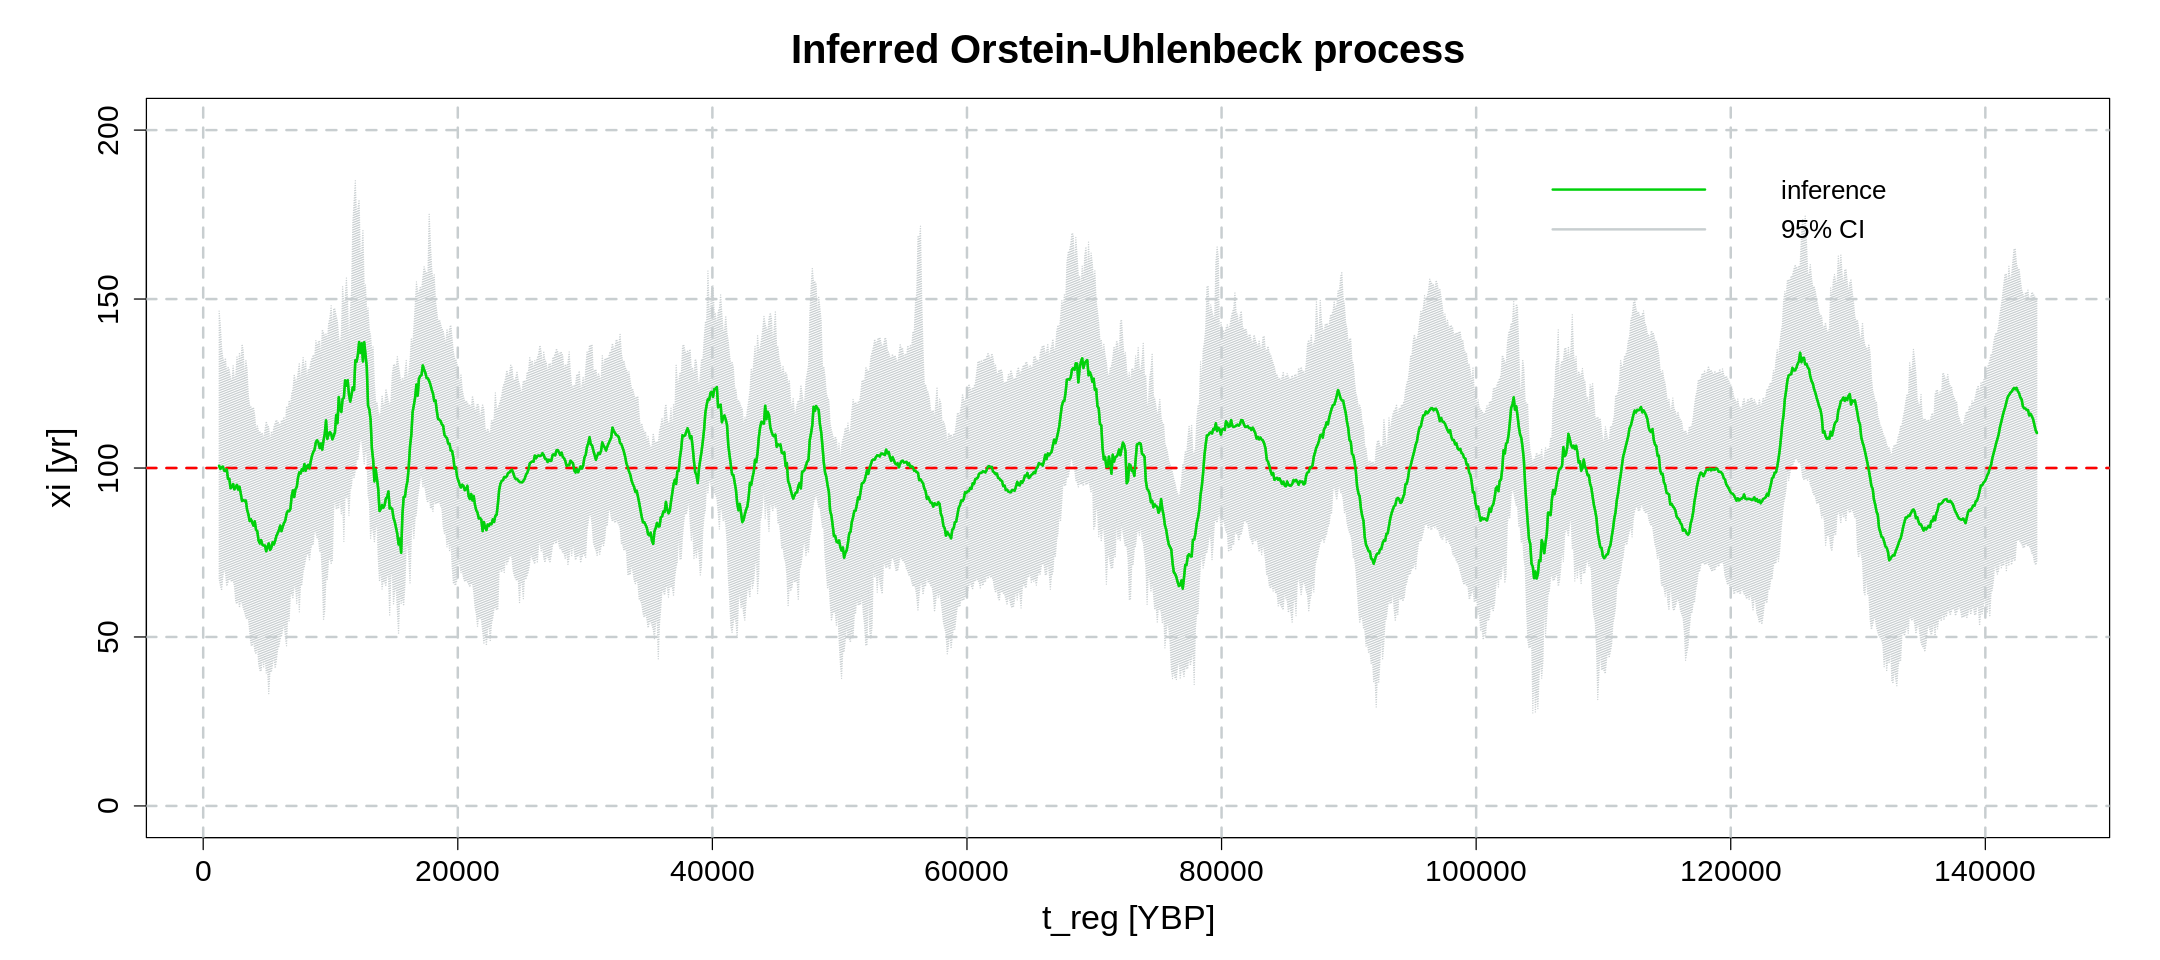

In [31]:
infer_OU(n, df_inf)

In [32]:
# plot trace (Markov chain) and histogram (marginal) of a t inferred parameter
traceplot <- function(param_t, param_t_inf, i, df) {
    
    key <- paste0('t.', i)
    
    # plot
    options(repr.plot.width = 14, repr.plot.height = 6)
    par(mfrow = c(1,2))

    # poetic variables
    sd <- apply(df['xi_sd'], 2, quantile, probs = 0.5)

    # trace
    
    plot(seq(1, nrow(df)), df[[key]], ylim = param_t[i] + 250*c(-sd, sd),
        main = 'Trace plot', xlab = 'iterations', ylab = paste(key,'[yr]'), type = 'l', col = col_blue)


    abline(h = param_t_inf[key], col = col_green, lty = 2, lwd = 2)
    abline(h = param_t[key], col = 'black', lty = 2, lwd = 2)

    legend(x = -0.05*nrow(df[key]), y = param_t[i] - 0.7*250*sd, bty = 'n', inset = 0.01,
        legend = c(paste0('inf ', key), paste0('reg ', key)),
        lty = rep(1,2), col = c(col_green, 'black'))

    # histogram
     
    h <- hist(df[[key]], breaks = 10,  xlim = param_t[i] + 250*c(-sd, sd),
        main = 'Marginalized posterior histogram', xlab = paste(key,'[yr]'), col = col_blue)
    box()

    abline(v = param_t_inf[key], col = col_green, lty = 2, lwd = 2)
    abline(v = param_t[i], col = 'black', lty = 2, lwd = 2)

    legend(x = param_t[i] - 1.1*250*sd, y = 1.01*max(h$counts), bty = 'n', inset = 0.01,
        legend = c(paste0('inf ', key), paste0('reg ', key)),
        lty = rep(1,2), col = c(col_green, 'black'))

}

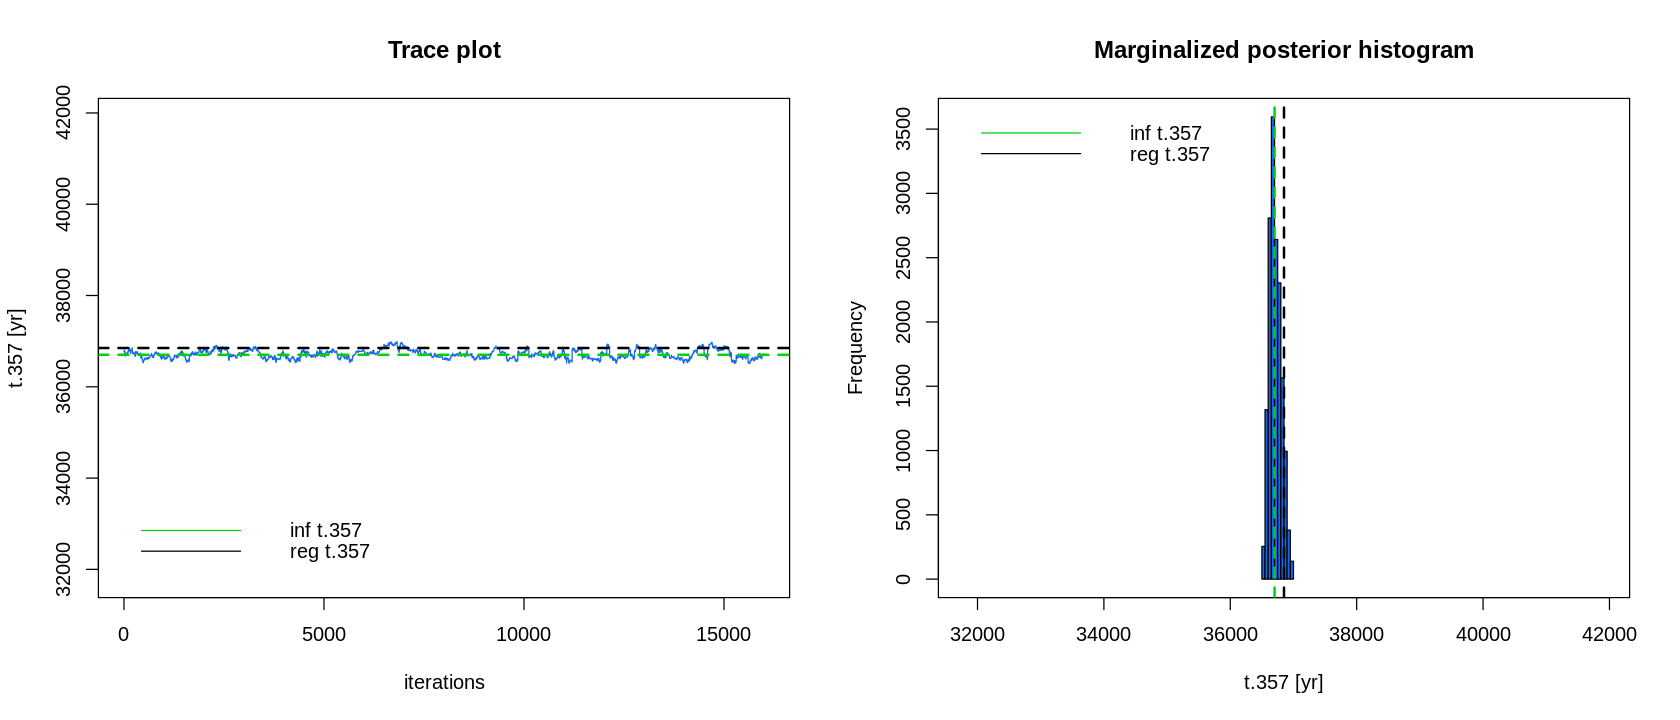

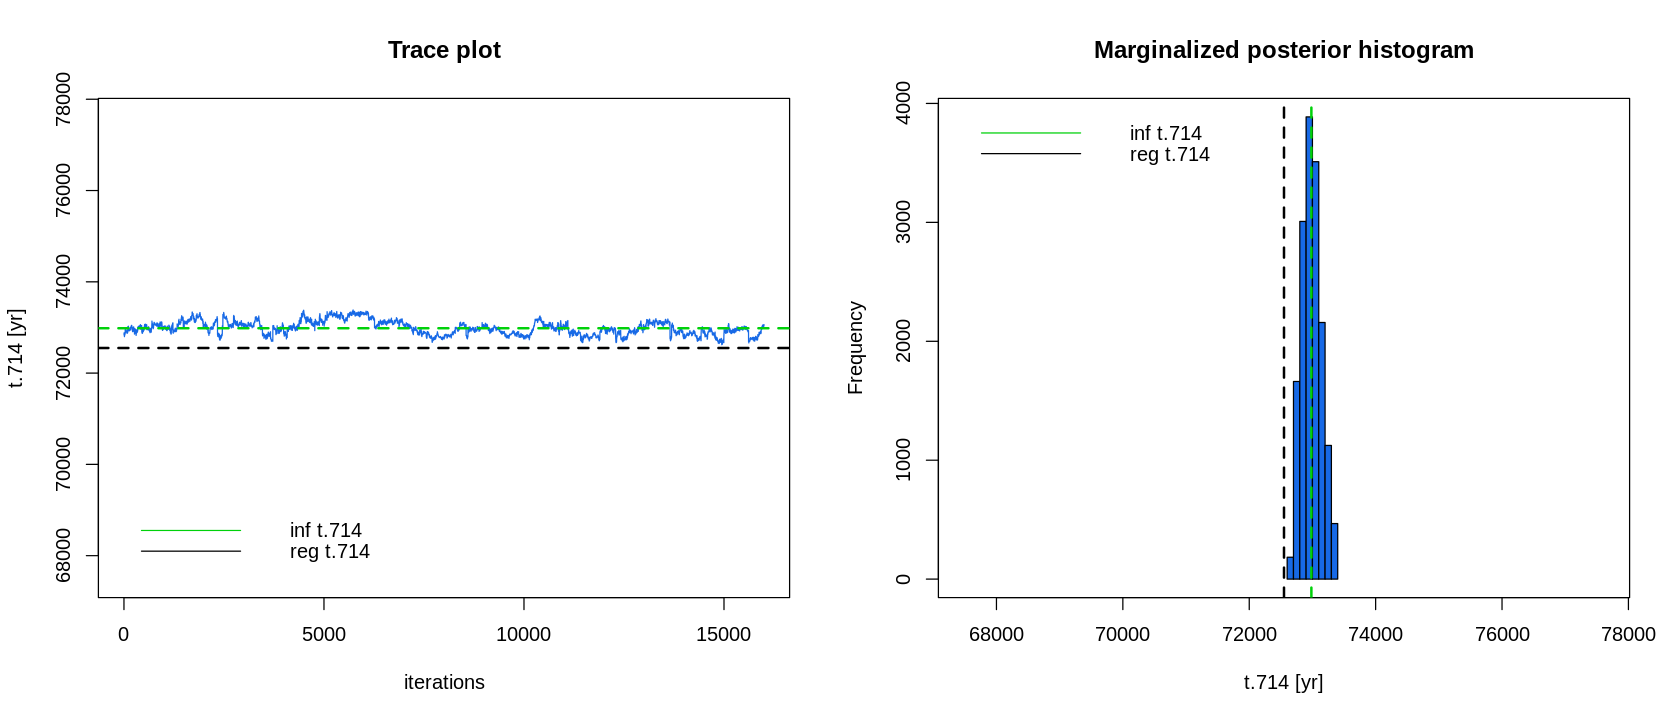

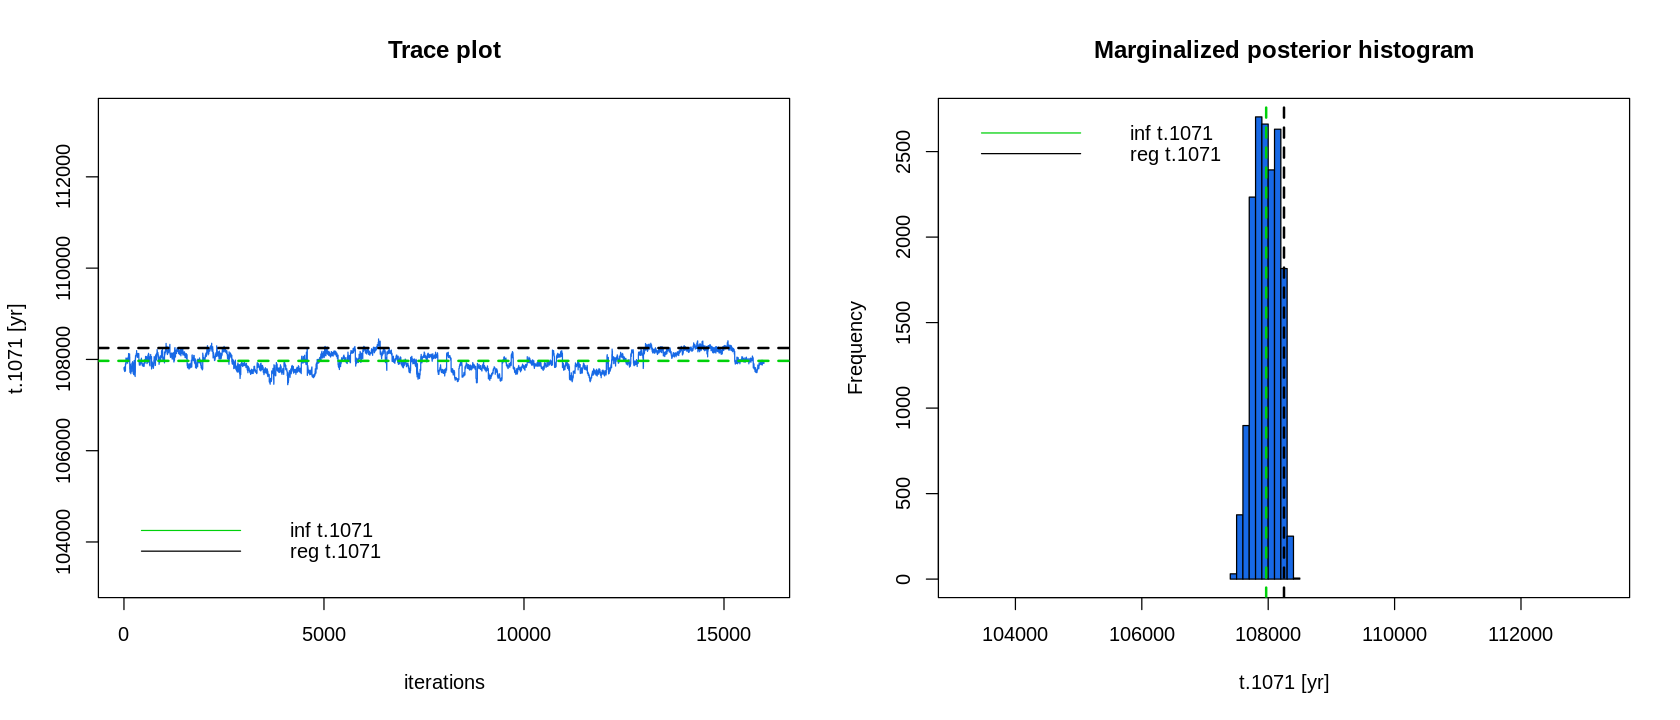

In [33]:
tis <- c(0.25*n, 0.5*n, 0.75*n)

for (i in tis) {
    traceplot(param_t, param_t_inf, as.integer(i), df_inf)
}

In [34]:
# 95% credible interval of t inferred parameters
param_t_inf_95CI <- apply(df_inf[names(param_t_inf)], 2, quantile, probs = c(0.025, 0.975))

In [35]:
# plot credible interval of all t inferred parameters
credible_interval <- function(param_t, param_t_inf, param_t_inf_95CI) {

    # shifted inferred value
    y_inf <- param_t_inf - param_t

    # plot
    options(repr.plot.width = 18, repr.plot.height = 8)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    plot(seq(1, length(y_inf)), y_inf, ylim = c(-1500, 1000),
        main = 'Difference between the inferred and regular time-scale',
        xlab = 'index', ylab = 'Δt [yr]',
        type = 'l', lty = 1, lwd = 2, col = col_green,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 2)

    polygon(c(seq(1, length(y_inf)), rev(seq(1, length(y_inf)))), 
            c(param_t_inf_95CI[1,] - param_t, rev(param_t_inf_95CI[2,] - param_t)),
            col = col_grey, density = 90, border = FALSE)

    abline(h = 0, col = 'black', lty = 2, lwd = 2)

    lines(seq(1, length(y_inf)), y_inf, type = 'l', lty = 1, lwd = 2, col = col_green)

    legend(x = 0.71*n, y = 970, bty = 'n',
        inset = 0.01,
        legend = c('inference', '95% CI'),
        lty = rep(1,3),
        col = c(col_green, col_grey),
        lwd = rep(2,3),
        cex = 1.3)

}

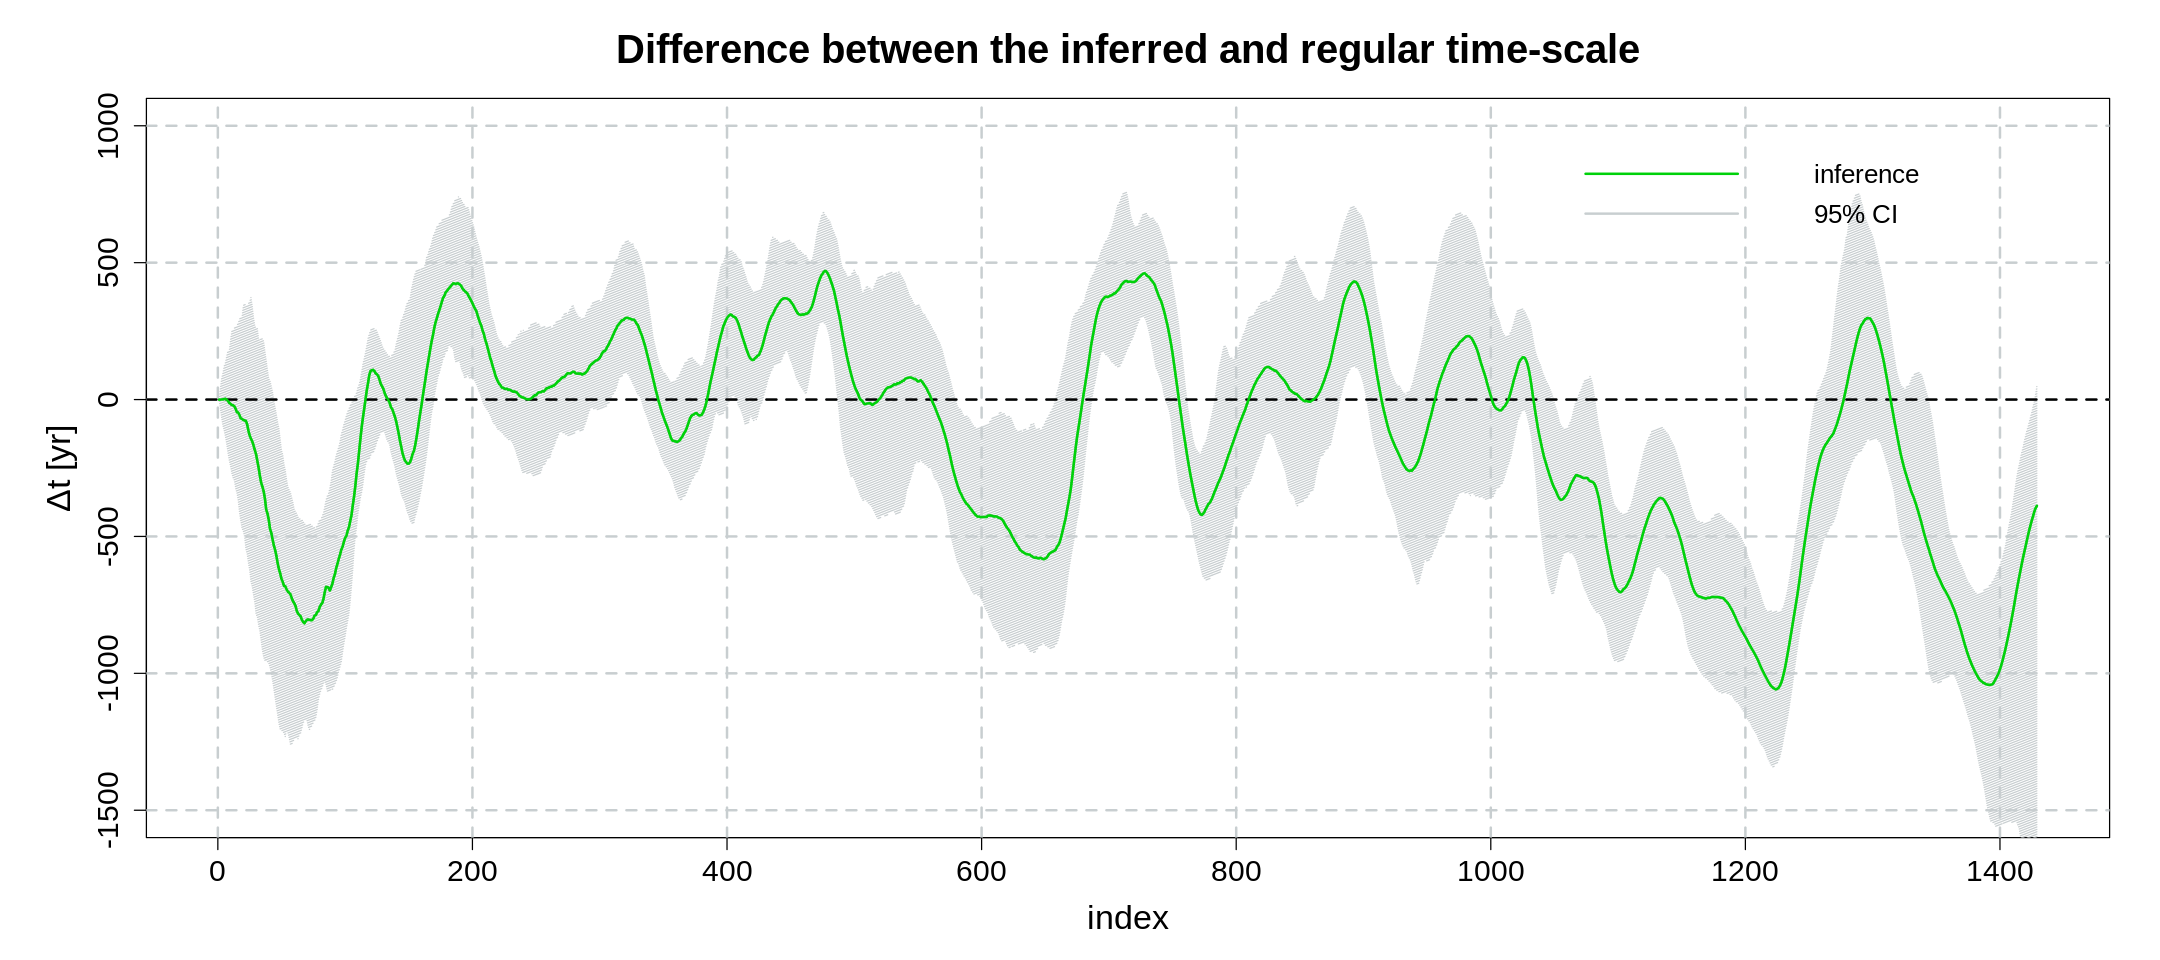

In [36]:
credible_interval(param_t, param_t_inf, param_t_inf_95CI)

In [37]:
# compute inferred fit
fit_corr = fit_data(param_A_inf, param_ph_inf, param_t_inf, freq, N_cycle_inf, n)

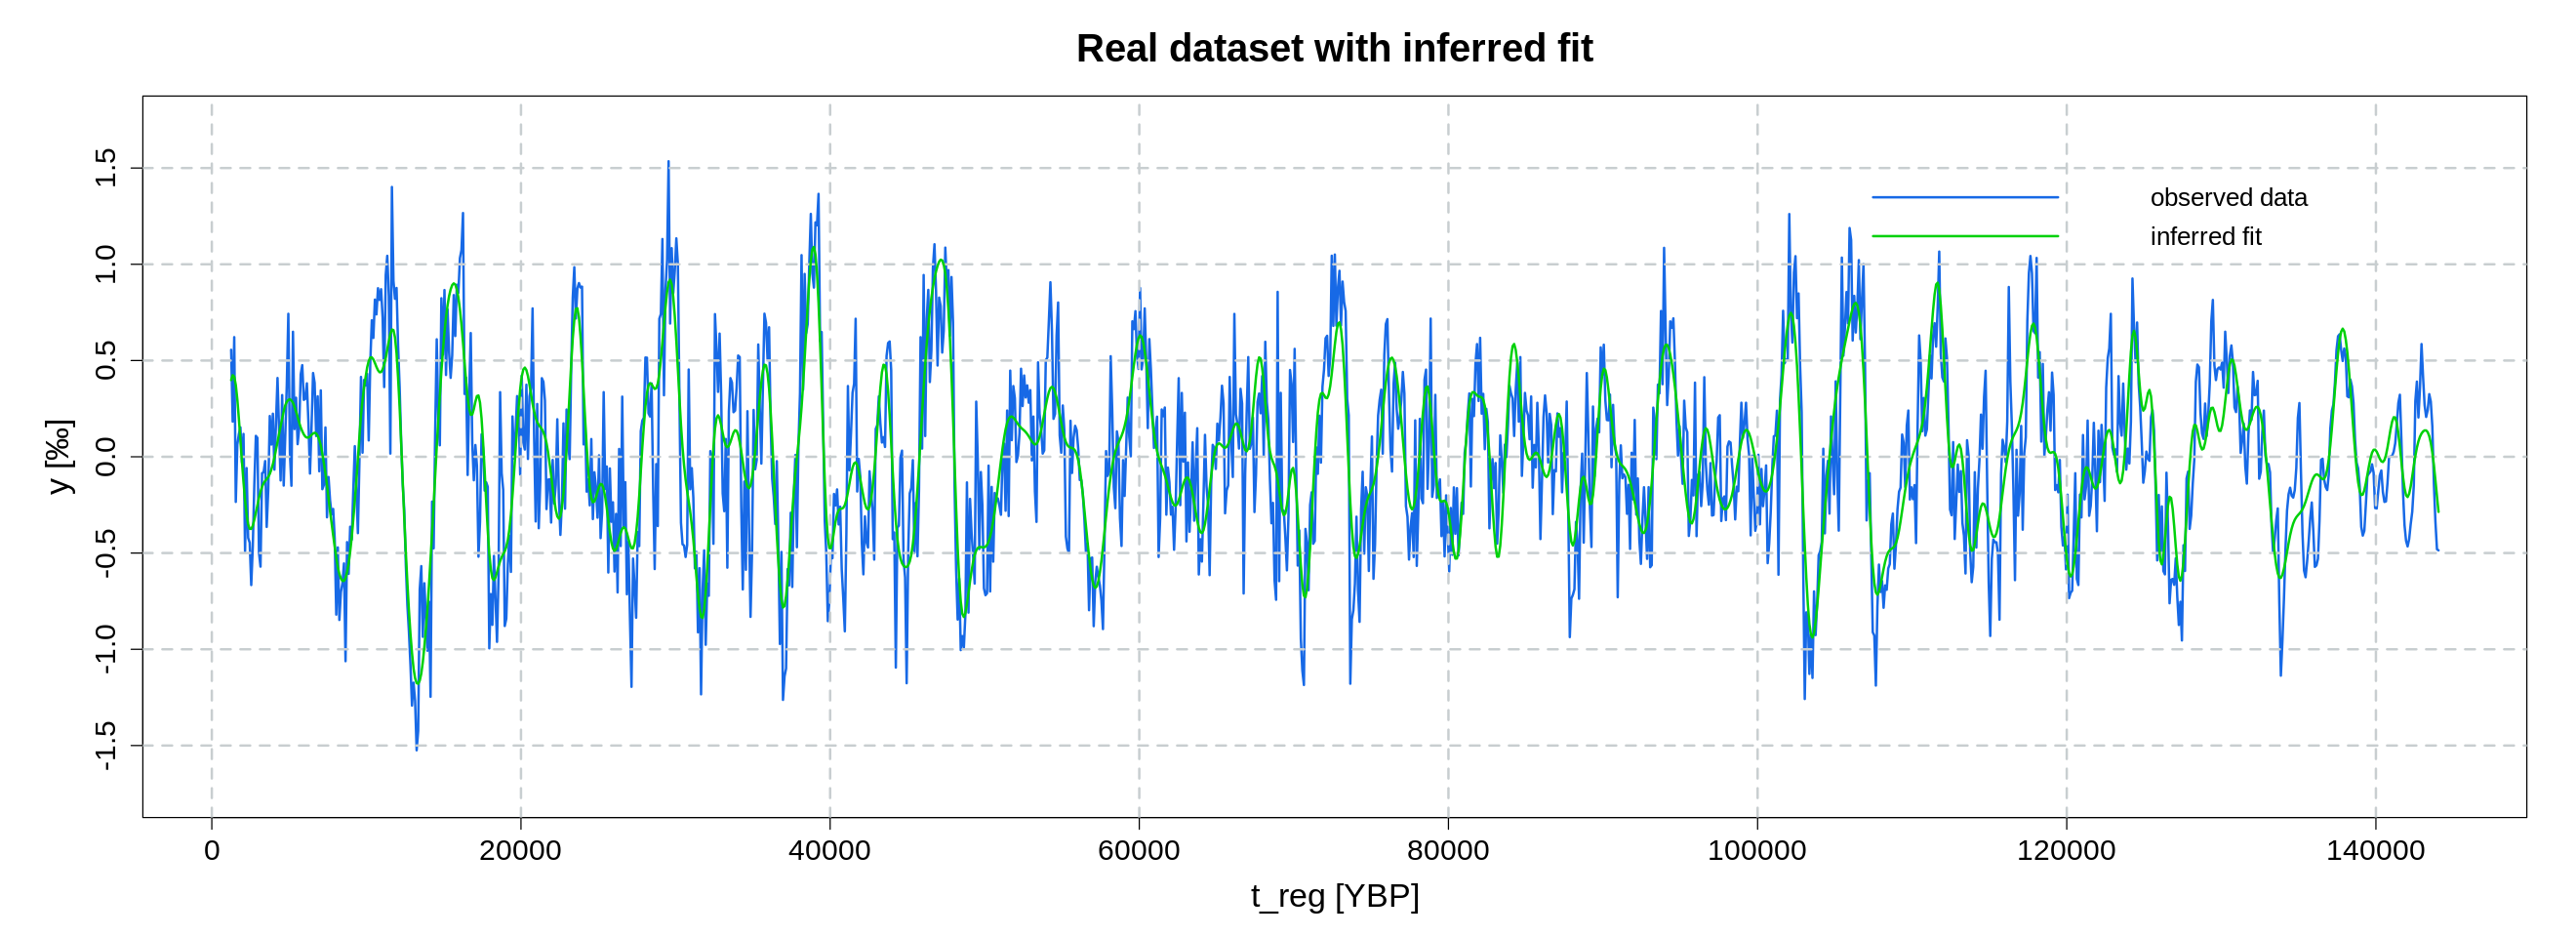

In [38]:
# plot inferred fit
plot_fit(df, fit_corr, 1, n, 'inferred fit')

In [39]:
# sum of squared residuals
ssr <- sum((df['y_obs'] - fit_bret)**2)
ssr_corr <- sum((df['y_obs'] - fit_corr)**2)

cat('ssr of Bretthorst method:', round(ssr,2), '\n')
cat('ssr of Bayesian inference with time-scale correction:', round(ssr_corr,2))

ssr of Bretthorst method: 233.59 
ssr of Bayesian inference with time-scale correction: 109.11

In [40]:
plot_inference <- function(df, param_t_inf, start, end) {

    param_t_inf <- param_t_inf[start:end]
    df <- df[start:end,]

    # plot
    options(repr.plot.width = 18, repr.plot.height = 8)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    # poetic variable
    sigma_y <- 0.2

    plot(df[['t']], df[['y_obs']],
        main = 'Time-scale correction',
        ylim = (max(df[['y_obs']]) + 1*sigma_y)*c(-1,1),
        xlab = 't [YBP]', ylab = 'y [‰]',
        type = 'l', lty = 1, lwd = 2, col = col_blue,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 2)

    lines(param_t_inf, df[['y_obs']],
        type = 'l', lty = 1, lwd = 2, col = col_green)

    legend(x = start*100 + 0.65*(end-start)*100, y = 1.5, bty = 'n',
        inset = 0.02,
        legend = c('observed data', 'corrupted data'),
        lty = rep(1,2),
        col = c(col_blue, col_green),
        lwd = rep(2,2),
        cex = 1.3)
}

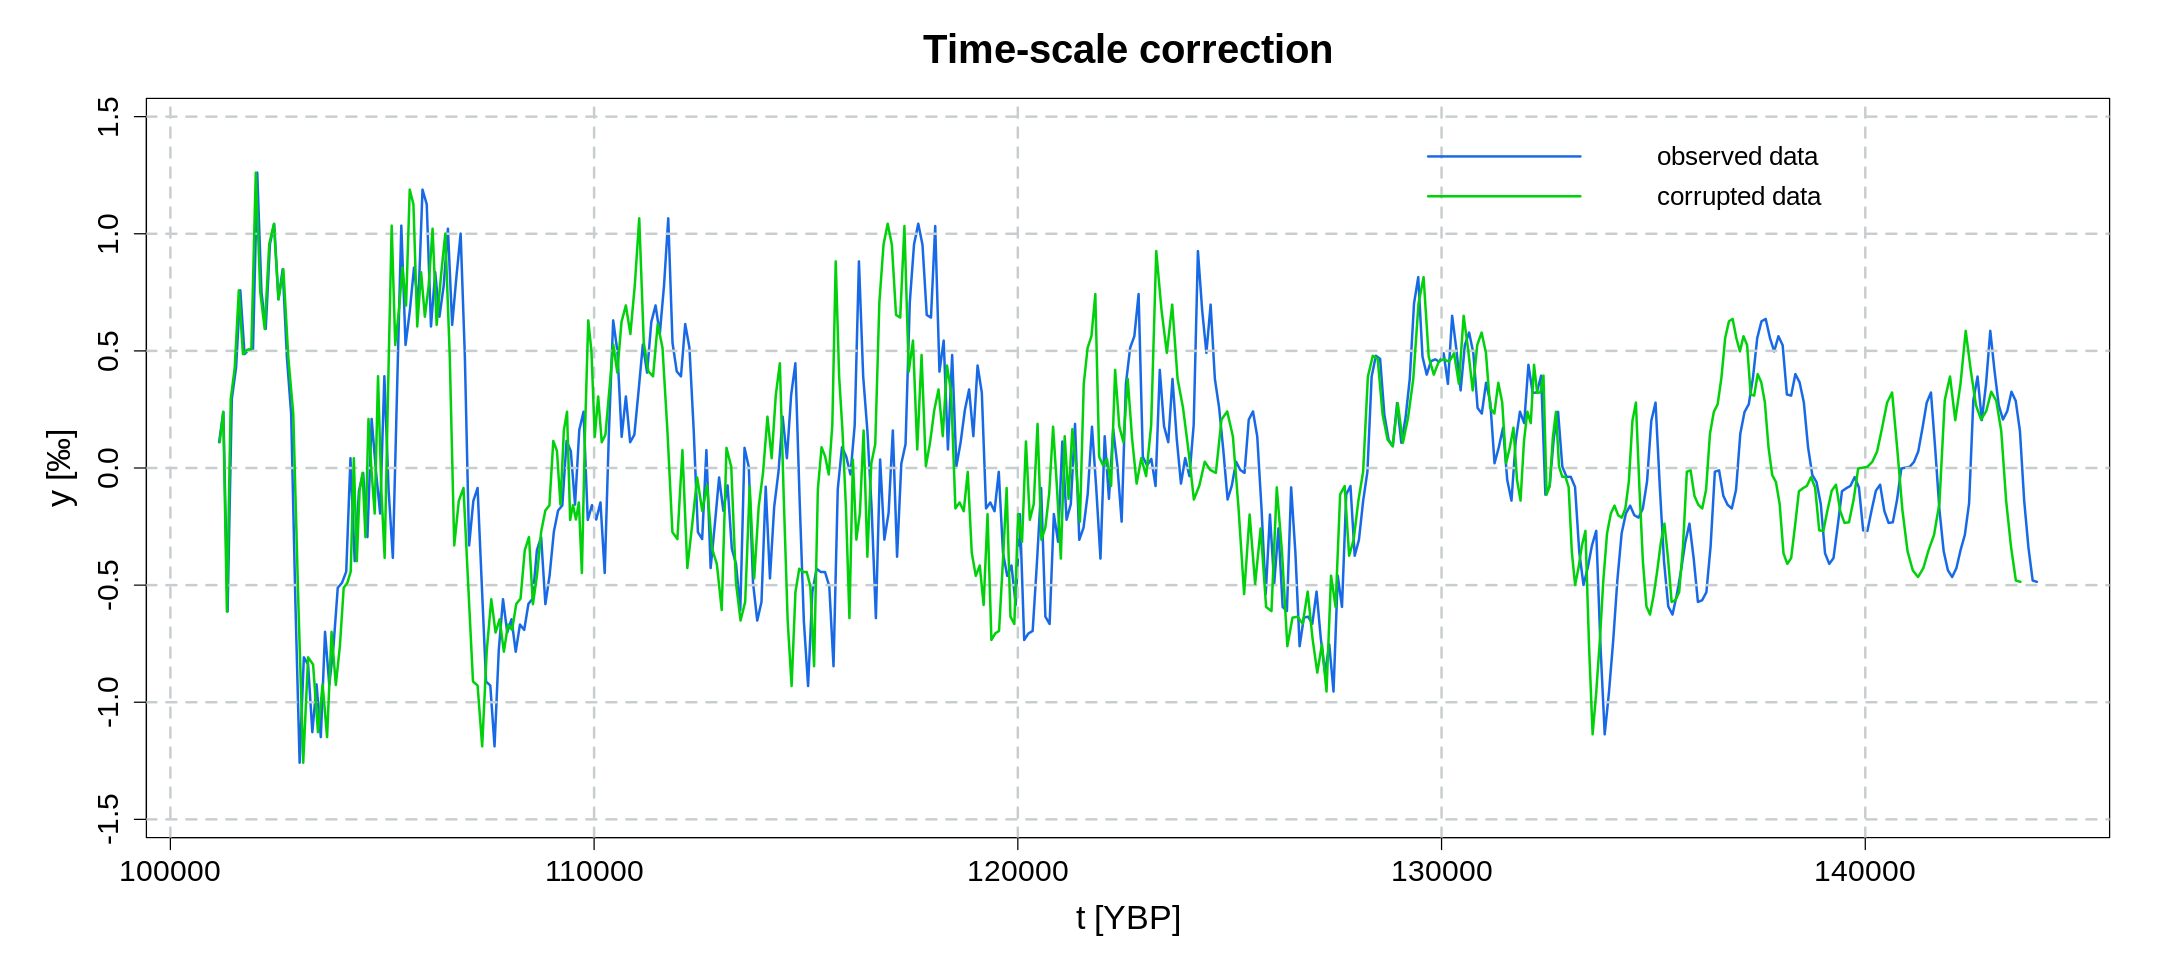

In [41]:
plot_inference(df, param_t_inf, 1000, n)